# Спортивный анализ данных. Платформа Kaggle

# Курсовой проект. EDA

## Описание источников данных:
1.	train.csv - пары "заявка - целевая переменная", для этой выборки нужно собрать признаки и обучить модель;
2.	test.csv - пары "заявки - прогнозное значение", для этой выборки нужно собрать признаки и построить прогнозы;
3.	bki.csv - данные БКИ о предыдущих кредитах клиента;
4.	client_profile.csv - клиентский профиль, некоторые знания, которые есть у компании о клиенте;
5.	payments.csv - история платежей клиента;
6.	applications_history.csv - история предыдущих заявок клиента.

## Подключение библиотек и скриптов

In [1]:
import time
import numpy as np
import pandas as pd

import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from pathlib import Path

pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
def get_input(dataset_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.
    
    Parametrs
    ---------
    dataset_path: str
        Название файла
        
    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame
    """
    
    data_root = Path('D:/DS_materials/208_kaggle/data_comp/')
    dataset = pd.read_csv(f'{data_root}/{dataset_path}')
    dataset.columns = [col.lower() for col in dataset.columns]
    print(f"{dataset_path} shape: {dataset.shape[0]} rows, {dataset.shape[1]} cols")

    return dataset

## Загрузка данных

In [3]:
train = get_input("train.csv")
test = get_input("test.csv")
history = get_input("applications_history.csv")
client_profile = get_input("client_profile.csv")
payments = get_input("payments.csv")
bki = get_input("bki.csv")

train.csv shape: 110093 rows, 3 cols
test.csv shape: 165141 rows, 2 cols
applications_history.csv shape: 1670214 rows, 26 cols
client_profile.csv shape: 250000 rows, 24 cols
payments.csv shape: 1023932 rows, 8 cols
bki.csv shape: 945234 rows, 17 cols


## Получение информации о данных

#### train

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110093 entries, 0 to 110092
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   application_number  110093 non-null  int64 
 1   target              110093 non-null  int64 
 2   name_contract_type  110093 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


In [5]:
train.iloc[0]

application_number    123687442
target                        0
name_contract_type         Cash
Name: 0, dtype: object

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165141 entries, 0 to 165140
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   application_number  165141 non-null  int64 
 1   name_contract_type  165141 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


#### history

In [7]:
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   prev_application_number    1670214 non-null  int64  
 1   application_number         1670214 non-null  int64  
 2   name_contract_type         940717 non-null   object 
 3   amount_annuity             1297979 non-null  float64
 4   amt_application            1670214 non-null  float64
 5   amount_credit              1670213 non-null  float64
 6   amount_payment             774370 non-null   float64
 7   amount_goods_payment       1284699 non-null  float64
 8   name_contract_status       1670214 non-null  object 
 9   days_decision              1670214 non-null  int64  
 10  name_payment_type          1670214 non-null  object 
 11  code_reject_reason         1670214 non-null  object 
 12  name_type_suite            849809 non-null   object 
 13  name_client_

In [8]:
history.iloc[0]

prev_application_number                   49298709
application_number                       123595216
name_contract_type                             NaN
amount_annuity                             1730.43
amt_application                            17145.0
amount_credit                              17145.0
amount_payment                                 0.0
amount_goods_payment                       17145.0
name_contract_status                      Approved
days_decision                                   73
name_payment_type            Cash through the bank
code_reject_reason                             XAP
name_type_suite                                NaN
name_client_type                          Repeater
name_goods_category                         Mobile
name_portfolio                                 POS
name_product_type                              XNA
sellerplace_area                                35
cnt_payment                                   12.0
name_yield_group               

In [9]:
# Базовые статистики по всем числовым значениям, за исключением пропусков
history.describe()

,prev_application_number,application_number,amount_annuity,amt_application,amount_credit,amount_payment,amount_goods_payment,days_decision,sellerplace_area,cnt_payment,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,4.919130e+07,1.236017e+08,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,8.806797e+02,3.139511e+02,1.605408e+01,342340.056543,15949.224065,35163.363265,78152.730207,83505.775017,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,7.790997e+02,7.127443e+03,1.456729e+01,88413.495220,72007.270877,106405.950190,148833.342466,152484.418802,0.471134
min,4.826822e+07,1.234233e+08,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,2.000000,2.000000,0.000000,2.000000,2.000000,0.000000
25%,4.873007e+07,1.235127e+08,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,2.800000e+02,-1.000000e+00,6.000000e+00,365243.000000,475.000000,257.000000,455.000000,447.000000,0.000000
50%,4.919132e+07,1.236021e+08,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,921.000000,741.000000,1155.000000,1171.000000,0.000000
75%,4.965249e+07,1.236909e+08,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.300000e+03,8.200000e+01,2.400000e+01,365243.000000,1825.000000,1735.000000,2418.000000,2501.000000,1.000000
max,5.011360e+07,1.237796e+08,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.922000e+03,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


#### client_profile

In [10]:
client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   application_number          250000 non-null  int64  
 1   gender                      250000 non-null  object 
 2   childrens                   250000 non-null  int64  
 3   total_salary                250000 non-null  float64
 4   amount_credit               250000 non-null  float64
 5   amount_annuity              249989 non-null  float64
 6   education_level             250000 non-null  object 
 7   family_status               250000 non-null  object 
 8   region_population           250000 non-null  float64
 9   age                         250000 non-null  int64  
 10  days_on_last_job            250000 non-null  int64  
 11  own_car_age                 85041 non-null   float64
 12  flag_phone                  250000 non-null  int64  
 13  flag_email    

In [11]:
client_profile.iloc[0]

application_number                    123666076
gender                                        F
childrens                                     0
total_salary                           157500.0
amount_credit                          270000.0
amount_annuity                          13500.0
education_level               Incomplete higher
family_status                    Civil marriage
region_population                      0.008068
age                                        8560
days_on_last_job                           1549
own_car_age                                 NaN
flag_phone                                    1
flag_email                                    0
family_size                                 2.0
external_scoring_rating_1              0.329471
external_scoring_rating_2              0.236315
external_scoring_rating_3              0.678568
amt_req_credit_bureau_hour                  0.0
amt_req_credit_bureau_day                   0.0
amt_req_credit_bureau_week              

In [12]:
# Базовые статистики по всем числовым значениям, за исключением пропусков
client_profile.describe()

,application_number,childrens,total_salary,amount_credit,amount_annuity,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
count,2.500000e+05,250000.000000,2.500000e+05,2.500000e+05,249989.000000,250000.000000,250000.000000,250000.000000,85041.000000,250000.000000,250000.000000,249998.000000,109121.000000,2.494680e+05,200462.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000
mean,1.235771e+08,0.417624,1.690662e+05,5.993051e+05,27125.209585,0.020871,16033.460496,67505.883296,12.030221,0.280244,0.057072,2.154025,0.502122,5.141749e-01,0.510848,0.006348,0.006866,0.034217,0.267475,0.266786,1.899030
std,8.877722e+04,0.722529,2.588480e+05,4.022720e+05,14503.930366,0.013827,4361.332320,139261.099609,11.899404,0.449119,0.231981,0.911543,0.210817,1.910938e-01,0.195054,0.083783,0.107957,0.204029,0.914514,0.831547,1.868811
min,1.234233e+08,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000290,7489.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.014691,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.235002e+08,0.000000,1.125000e+05,2.700000e+05,16524.000000,0.010006,12415.000000,931.000000,5.000000,0.000000,0.000000,2.000000,0.334180,3.920026e-01,0.370650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.235772e+08,0.000000,1.485000e+05,5.147775e+05,24930.000000,0.018850,15744.000000,2217.000000,9.000000,0.000000,0.000000,2.000000,0.506018,5.656713e-01,0.535276,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.236540e+08,1.000000,2.025000e+05,8.086500e+05,34618.500000,0.028663,19681.000000,5678.000000,15.000000,1.000000,0.000000,3.000000,0.674793,6.635195e-01,0.669057,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.237309e+08,19.000000,1.170000e+08,4.050000e+06,230161.500000,0.072508,25229.000000,365243.000000,69.000000,1.000000,1.000000,20.000000,0.962693,8.549997e-01,0.896010,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


#### payments

In [13]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023932 entries, 0 to 1023931
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   prev_application_number  1023932 non-null  int64  
 1   application_number       1023932 non-null  int64  
 2   num_instalment_version   1023932 non-null  float64
 3   num_instalment_number    1023932 non-null  int64  
 4   days_instalment          1023932 non-null  float64
 5   days_entry_payment       1023729 non-null  float64
 6   amt_instalment           1023932 non-null  float64
 7   amt_payment              1023729 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 62.5 MB


In [14]:
payments.iloc[0]

prev_application_number    4.901118e+07
application_number         1.236650e+08
num_instalment_version     1.000000e+00
num_instalment_number      5.000000e+00
days_instalment            1.002000e+03
days_entry_payment         1.015000e+03
amt_instalment             1.215661e+04
amt_payment                1.215661e+04
Name: 0, dtype: float64

In [15]:
# Базовые статистики по всем числовым значениям, за исключением пропусков
payments.describe()

,prev_application_number,application_number,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment
count,1.023932e+06,1.023932e+06,1.023932e+06,1.023932e+06,1.023932e+06,1.023729e+06,1.023932e+06,1.023729e+06
mean,4.917253e+07,1.236018e+08,8.569114e-01,1.888052e+01,1.042505e+03,1.051378e+03,1.714263e+04,1.733931e+04
std,5.363093e+05,1.027412e+05,1.053180e+00,2.669996e+01,8.013580e+02,8.009974e+02,5.130650e+04,5.557338e+04
min,4.826822e+07,1.234233e+08,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
25%,4.870325e+07,1.235130e+08,0.000000e+00,4.000000e+00,3.610000e+02,3.700000e+02,4.217445e+03,3.386205e+03
50%,4.916602e+07,1.236020e+08,1.000000e+00,8.000000e+00,8.170000e+02,8.260000e+02,8.878500e+03,8.115390e+03
75%,4.963797e+07,1.236910e+08,1.000000e+00,1.900000e+01,1.655000e+03,1.664000e+03,1.671229e+04,1.611140e+04
max,5.011171e+07,1.237796e+08,1.780000e+02,2.750000e+02,2.922000e+03,3.054000e+03,2.860377e+06,2.860377e+06


#### bki

In [16]:
bki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945234 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   application_number      945234 non-null  int64  
 1   bureau_id               945234 non-null  int64  
 2   credit_active           945234 non-null  object 
 3   credit_currency         945234 non-null  object 
 4   days_credit             945234 non-null  float64
 5   credit_day_overdue      945234 non-null  int64  
 6   days_credit_enddate     886797 non-null  float64
 7   days_enddate_fact       596274 non-null  float64
 8   amt_credit_max_overdue  326557 non-null  float64
 9   cnt_credit_prolong      945234 non-null  int64  
 10  amt_credit_sum          945229 non-null  float64
 11  amt_credit_sum_debt     803483 non-null  float64
 12  amt_credit_sum_limit    619267 non-null  float64
 13  amt_credit_sum_overdue  945234 non-null  float64
 14  credit_type         

In [17]:
bki.iloc[0]

application_number              123538884
bureau_id                         5223613
credit_active                      Active
credit_currency                currency 1
days_credit                         718.0
credit_day_overdue                      0
days_credit_enddate                 377.0
days_enddate_fact                     NaN
amt_credit_max_overdue           19386.81
cnt_credit_prolong                      0
amt_credit_sum                   675000.0
amt_credit_sum_debt            320265.495
amt_credit_sum_limit                  0.0
amt_credit_sum_overdue                0.0
credit_type               Consumer credit
days_credit_update                   39.0
amt_annuity                           NaN
Name: 0, dtype: object

In [18]:
bki[bki['application_number'] == 123538884]

,application_number,bureau_id,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
789004,123538884,5279242,Closed,currency 1,581.0,0,369.0,398.0,0.00,0,57101.94,0.000,0.0,0.0,Consumer credit,398.0,NaN
830051,123538884,5294340,Active,currency 1,727.0,0,1099.0,NaN,NaN,0,517500.00,388044.000,0.0,0.0,Consumer credit,45.0,NaN


In [20]:
# Базовые статистики по всем числовым значениям, за исключением пропусков
bki.describe()

,application_number,bureau_id,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,days_credit_update,amt_annuity
count,9.452340e+05,9.452340e+05,945234.000000,945234.000000,886797.000000,596274.000000,3.265570e+05,945234.000000,9.452290e+05,8.034830e+05,6.192670e+05,9.452340e+05,945234.000000,2.693300e+05
mean,1.236016e+08,5.974377e+06,1142.218231,0.769791,1819.607174,1018.001196,3.784219e+03,0.006330,3.547738e+05,1.361747e+05,6.267718e+03,3.826128e+01,594.056297,1.646679e+04
std,1.029041e+05,5.330431e+05,795.047305,35.173550,4684.447770,715.013564,2.133823e+05,0.094857,1.078781e+06,6.370282e+05,4.528027e+04,5.156032e+03,721.505604,3.937657e+05
min,1.234233e+08,5.001084e+06,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,0.000000,0.000000e+00
25%,1.235122e+08,5.513773e+06,474.000000,0.000000,383.000000,426.000000,0.000000e+00,0.000000,5.121000e+04,0.000000e+00,0.000000e+00,0.000000e+00,33.000000,0.000000e+00
50%,1.236014e+08,5.976502e+06,987.000000,0.000000,863.000000,897.000000,0.000000e+00,0.000000,1.254708e+05,0.000000e+00,0.000000e+00,0.000000e+00,396.000000,0.000000e+00
75%,1.236908e+08,6.435551e+06,1666.000000,0.000000,1504.000000,1489.000000,0.000000e+00,0.000000,3.150000e+05,3.973275e+04,0.000000e+00,0.000000e+00,908.000000,1.350000e+04
max,1.237796e+08,6.942186e+06,2922.000000,2792.000000,42060.000000,42023.000000,1.159872e+08,7.000000,3.960000e+08,6.544140e+07,4.705600e+06,2.387232e+06,41943.000000,1.184534e+08


In [21]:
stat_data = pd.DataFrame(columns=['train', 'test', 'history', 'client_profile', 'payments', 'bki' ])

In [22]:
def basic_analysis(data, data_name):
    
    stat_data.loc['Rows count', data_name] = data.shape[0]
    stat_data.loc['Columns count', data_name] = data.shape[1]
    
    dict_dtypes = {}
    for i in data.dtypes.unique():
        dict_dtypes[i] = 0
    for j in data.dtypes:
        dict_dtypes[j] += 1  
    for k, v in dict_dtypes.items():
        stat_data.loc[f'Count of {k} features', data_name] = v
        
    list_nan = 0
    for i in data.count():
        if i != data.shape[0]:
            list_nan += 1
    stat_data.loc[f'Count of NaN', data_name] = list_nan
    
    list_disc = 0
    list_cont = 0
    for i in data.columns:
        if data[i].dtype != object:
            if data[i].nunique() < 25:
                list_disc += 1
            else:
                list_cont += 1          
    stat_data.loc[f'Discrete variables count', data_name] = list_disc
    stat_data.loc[f'Continuous features count', data_name] = list_cont
    

In [23]:
basic_analysis(data=train, data_name='train')
basic_analysis(data=test, data_name='test')
basic_analysis(data=history, data_name='history')
basic_analysis(data=client_profile, data_name='client_profile')
basic_analysis(data=payments, data_name='payments')
basic_analysis(data=bki, data_name='bki')

In [24]:
stat_data

,train,test,history,client_profile,payments,bki
Rows count,110093,165141,1670214,250000,1023932,945234
Columns count,3,2,26,24,8,17
Count of int64 features,2,1,4,6,3,4
Count of object features,1,1,10,3,NaN,3
Count of NaN,0,0,13,12,2,7
Discrete variables count,1,0,1,9,0,1
Continuous features count,1,1,15,12,8,13
Count of float64 features,NaN,NaN,12,15,5,10


### Анализ пропусков

<AxesSubplot:>

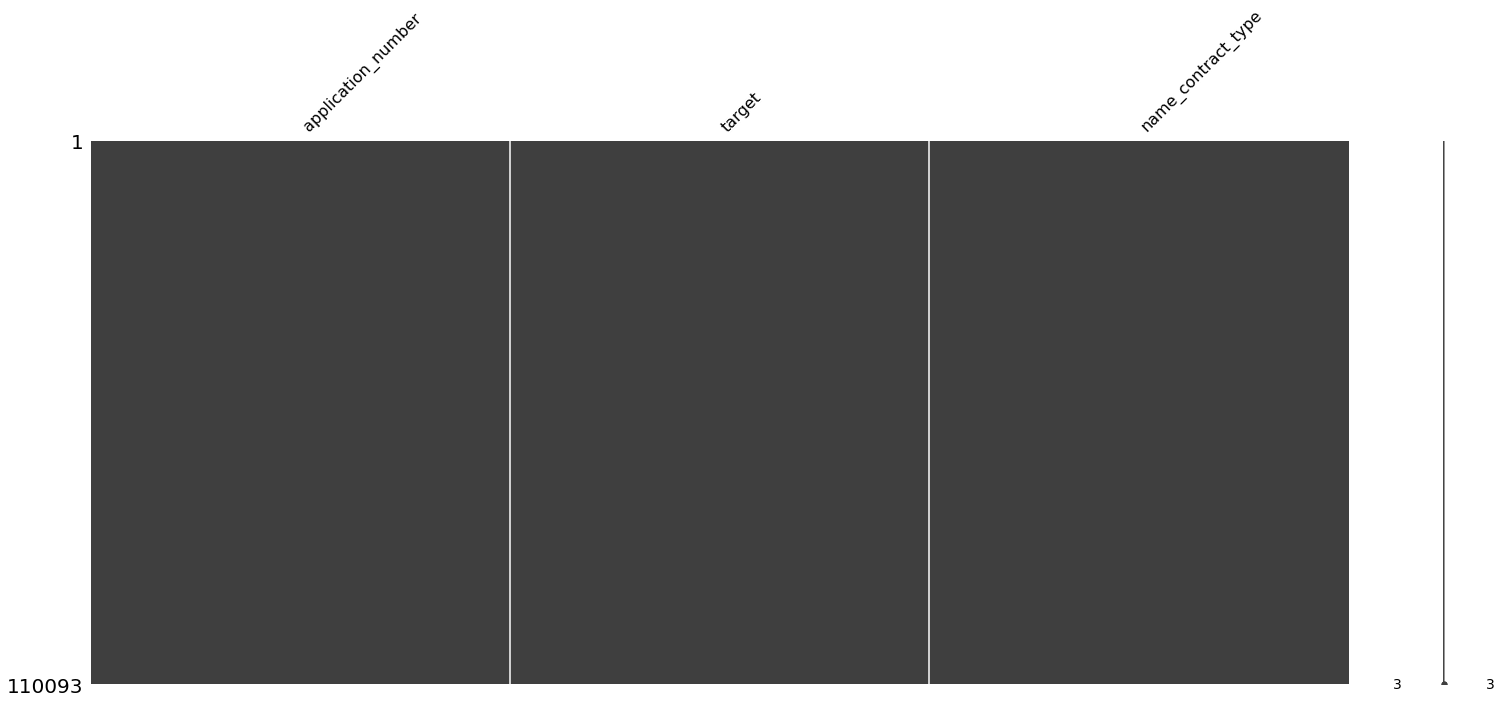

In [25]:
msno.matrix(train)

<AxesSubplot:>

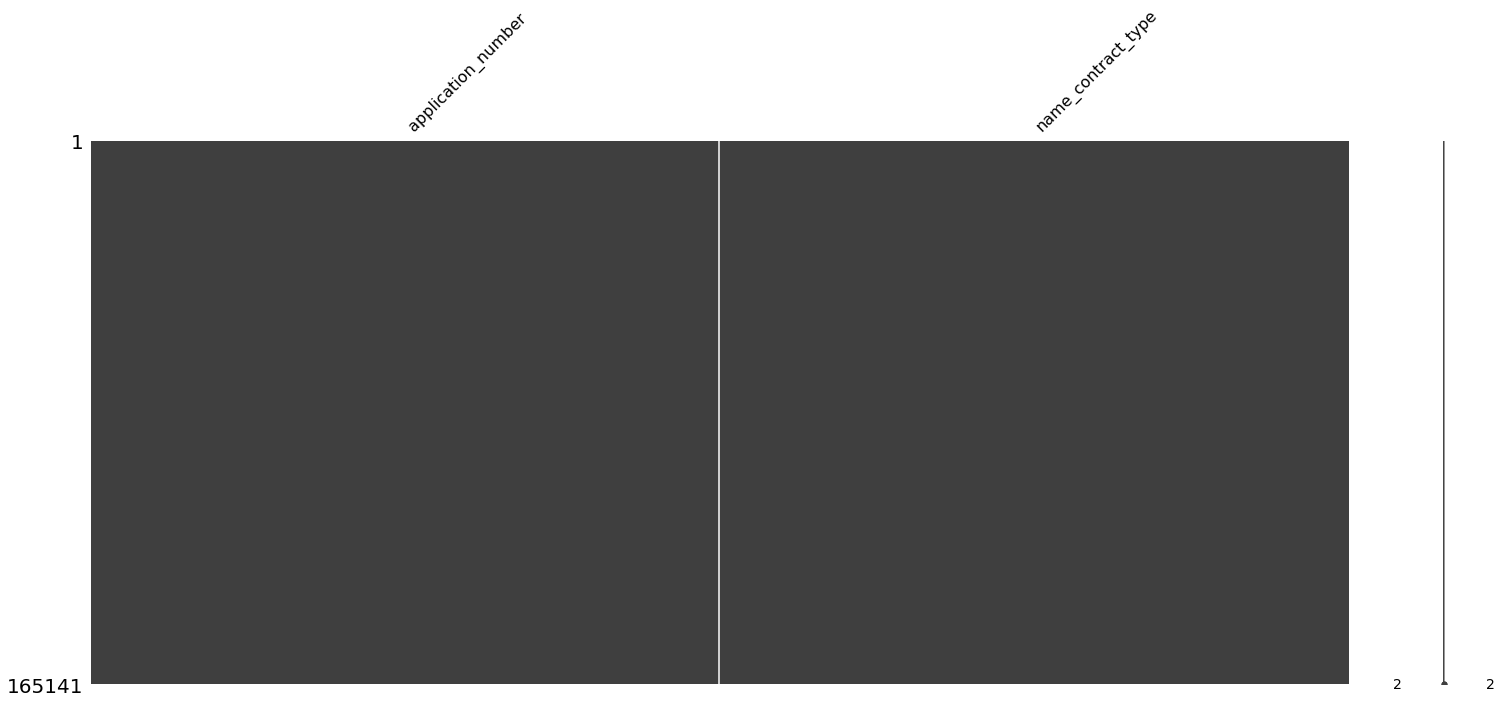

In [26]:
msno.matrix(test)

<AxesSubplot:>

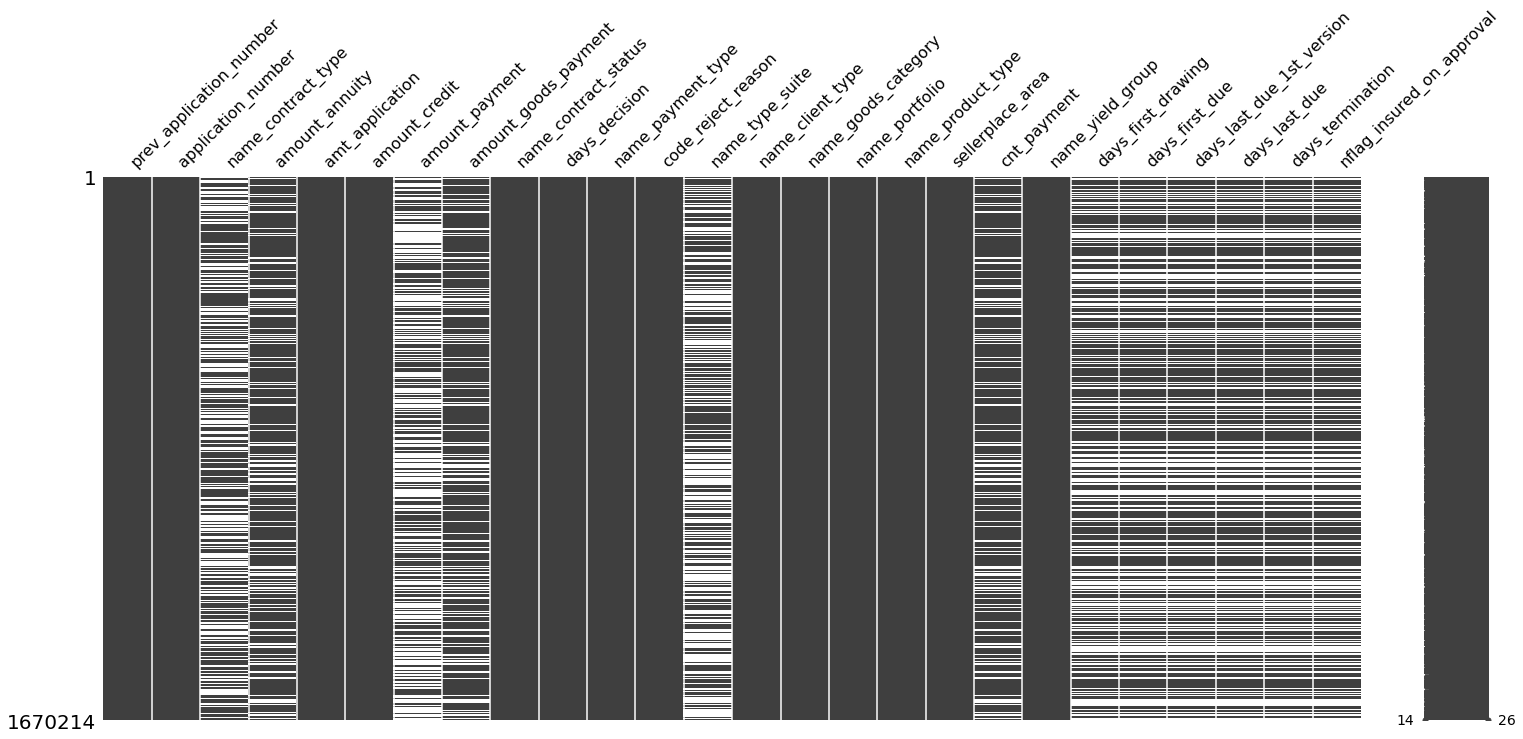

In [27]:
msno.matrix(history)

<AxesSubplot:>

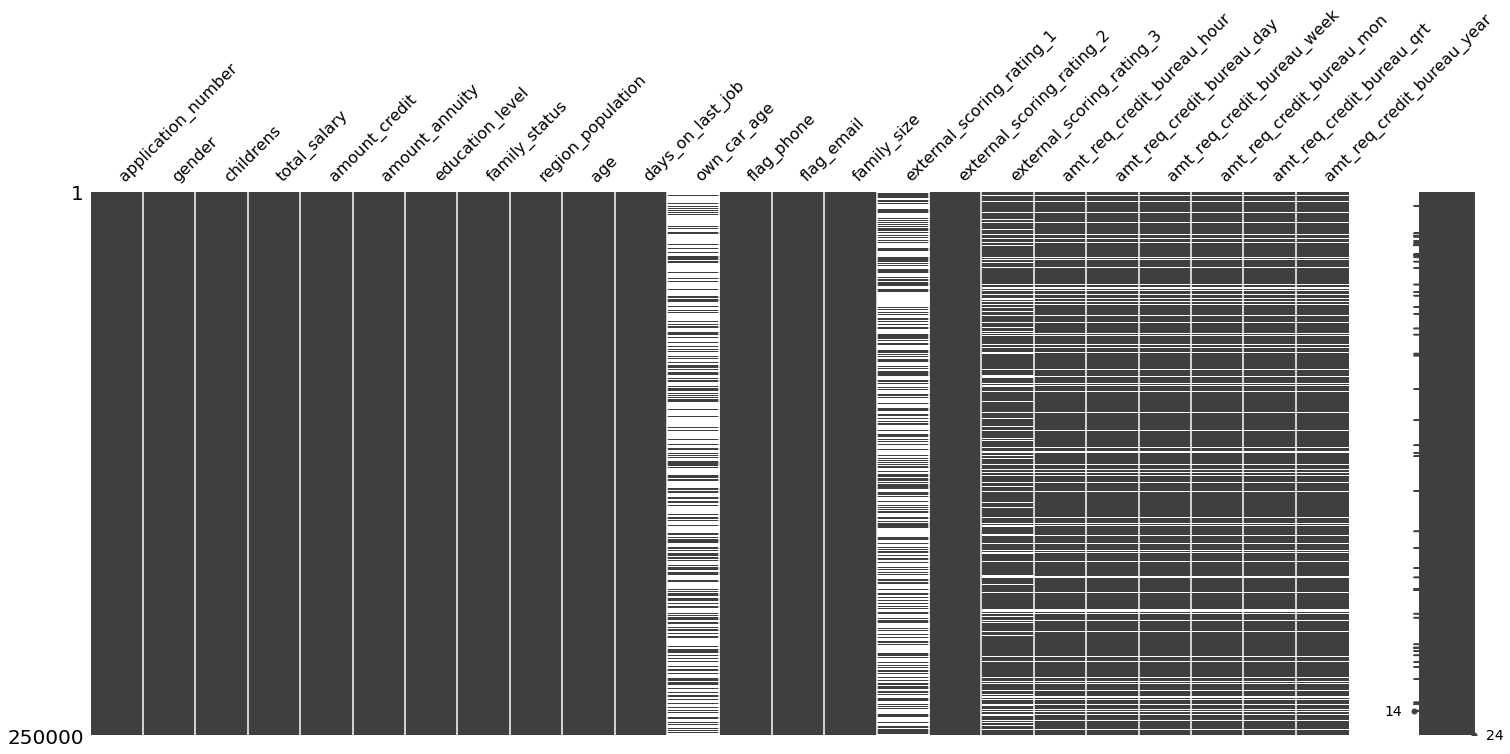

In [28]:
msno.matrix(client_profile)

<AxesSubplot:>

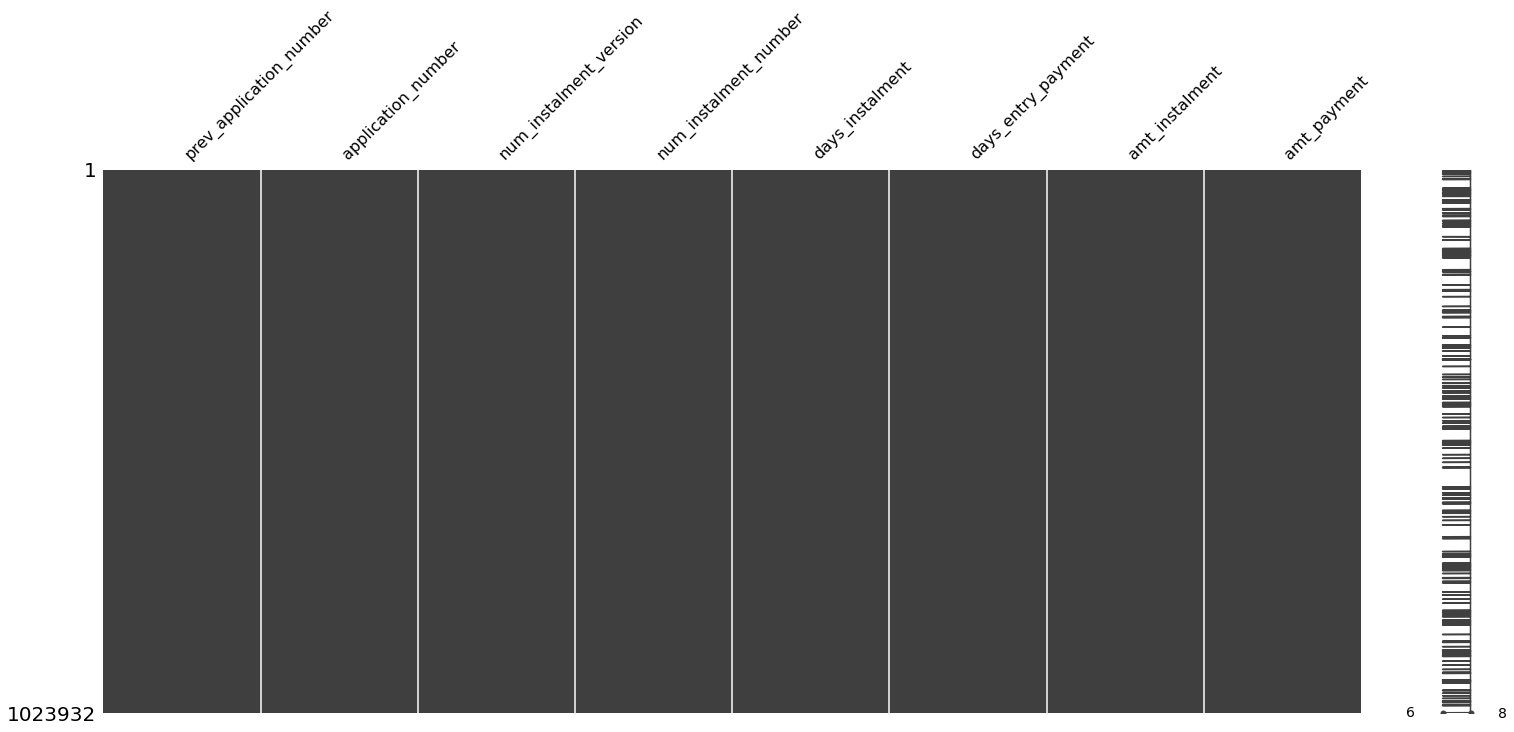

In [29]:
msno.matrix(payments)

<AxesSubplot:>

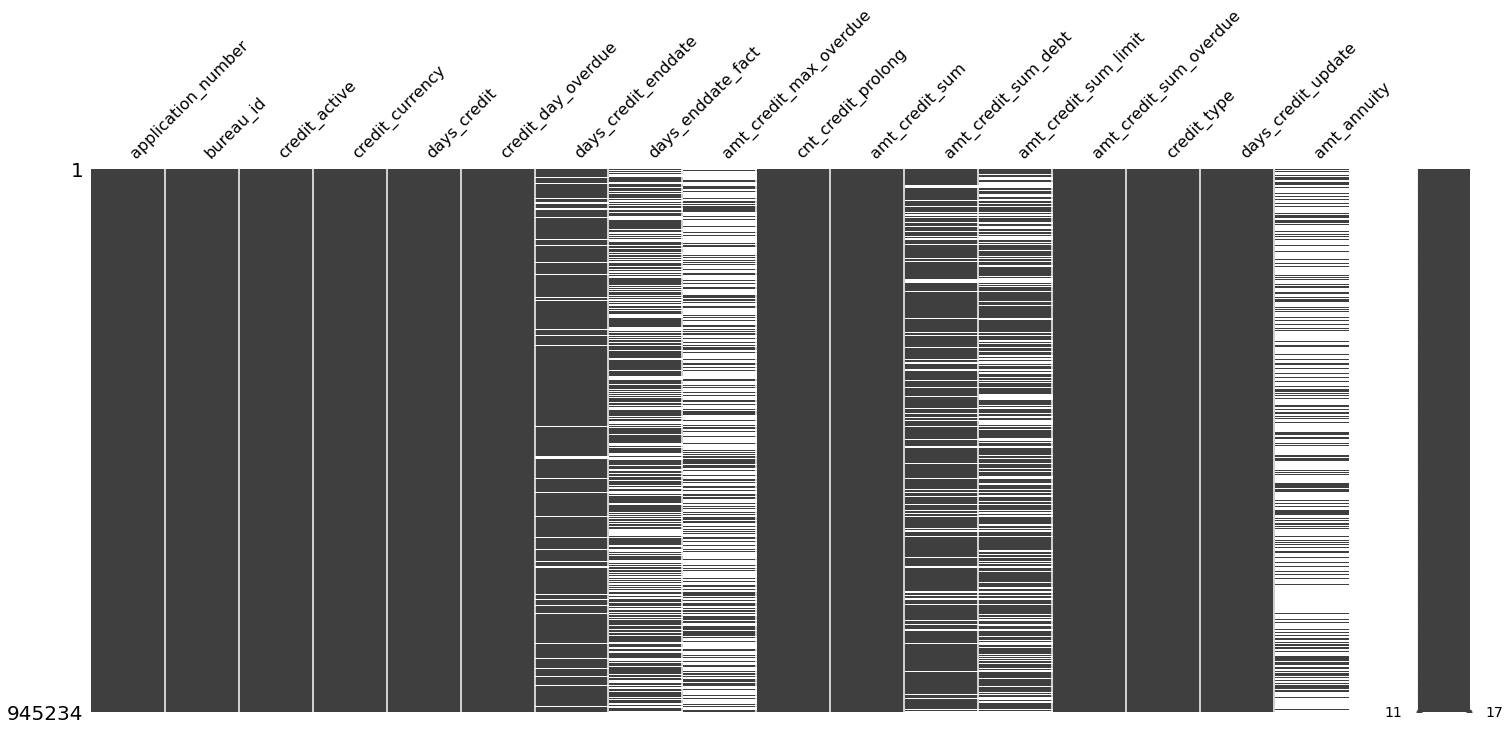

In [30]:
msno.matrix(bki)

1. В наборах данных `train`, `test`, `payments` пропусков нет

2. В наборе данных `payments` имеются пропуски в 12 признаках:
    * `days_first_drawing`, `days_first_due`,
       `days_last_due_1st_version`, `days_last_due`, `days_termination`,
       `nflag_insured_on_approval` - имеют схожие по рисунку пропуски
    * `amount_annuity`, `amount_goods_payment`, `cnt_payment` - имеют схожие по рисунку пропуски
    * `name_contract_type`
    * `amount_payment`
    * `name_type_suite`

3. В наборе данных `client_profile` имеются пропуски в 9 признаках:
    *  `amt_req_credit_bureau_hour`, `amt_req_credit_bureau_day`,
       `amt_req_credit_bureau_week`, `amt_req_credit_bureau_mon`,
       `amt_req_credit_bureau_qrt`, `amt_req_credit_bureau_year` - имеют схожие по рисунку пропуски
    * `own_car_age`
    * `external_scoring_rating_1`
    * `external_scoring_rating_3`

4. В наборе данных `bki` имеются пропуски в 6 признаках:
    * `days_credit_enddate`, `days_enddate_fact`, `amt_credit_max_overdue`, `amt_credit_sum_debt`, `amt_credit_sum_limit`, `amt_annuity`

## Анализ распределения целевой переменной

Positive examples = 8897
Negative examples = 101196
Proportion of positive to negative examples = 8.79%


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


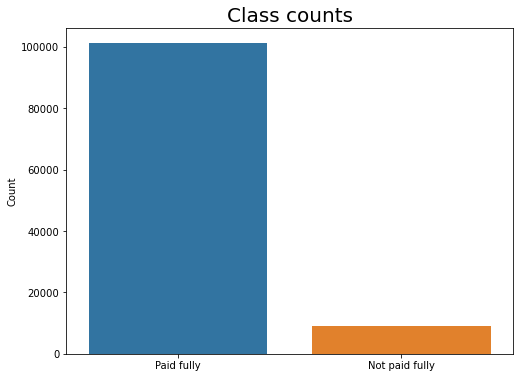

In [33]:
# Get number of positve and negative examples
pos = train[train["target"] == 1].shape[0]
neg = train[train["target"] == 0].shape[0]
print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(pos / neg) * 100:.2f}%")
plt.figure(figsize=(8, 6))
sns.countplot(train["target"])
plt.xticks((0, 1), ["Paid fully", "Not paid fully"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20});